# Data Modeling

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os

#import required modules from scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix,precision_score, recall_score
from sklearn.preprocessing import StandardScaler

#import algorithms modules
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
pd.options.display.max_columns = 100

In [3]:
libdir = os.chdir(r'C:\Users\Nidhi\Desktop\Saransh\FraudDetection')

In [4]:
file = r'./data/interim/preprocessed.csv'
df = pd.read_csv(file,nrows = 750000)
df.head(10)

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFlaggedFraud_0,isFlaggedFraud_1,CustTypeOrig_Customer,CustTypeDest_Customer,CustTypeDest_Merchant,Day_1.0,Day_10.0,Day_11.0,Day_12.0,Day_13.0,Day_14.0,Day_15.0,Day_16.0,Day_17.0,Day_18.0,Day_19.0,Day_2.0,Day_20.0,Day_21.0,Day_22.0,Day_23.0,Day_24.0,Day_25.0,Day_26.0,Day_27.0,Day_28.0,Day_29.0,Day_3.0,Day_30.0,Day_31.0,Day_32.0,Day_4.0,Day_5.0,Day_6.0,Day_7.0,Day_8.0,Day_9.0,Hour_0,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,transferAmntCheck_1
0,9839.64,170136.00,160296.36,0.0,0.00,0,0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1864.28,21249.00,19384.72,0.0,0.00,0,0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,181.00,181.00,0.00,0.0,0.00,1,0,0,0,0,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,181.00,181.00,0.00,21182.0,0.00,1,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,11668.14,41554.00,29885.86,0.0,0.00,0,0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,7817.71,53860.00,46042.29,0.0,0.00,0,0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,7107.77,183195.00,176087.23,0.0,0.00,0,0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,7861.64,176087.23,168225.59,0.0,0.00,0,0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,4024.36,2671.00,0.00,0.0,0.00,0,0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,5337.77,41720.00,36382.23,41898.0,40348.79,0,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [5]:
print('Dataset shape is:',df.shape)

Dataset shape is: (750000, 73)


In [6]:
#Splitting the dataset into X and y to further feed into the model(s)

X = df.drop('isFraud', axis = 1)
y = df.isFraud

print('The shape of independent dataset X is:',X.shape)
print('The shape of dependent/predicting dataset y is:',y.shape)

The shape of independent dataset X is: (750000, 72)
The shape of dependent/predicting dataset y is: (750000,)


<font color=blue><b>Due to the highly imbalanced nature of the dataset, it is imperative to handle the imbalanceness otherwise this may cause inaccurate results resulting in models with high accuracy scores but actually not performing well.</font></b>

In [7]:
y.value_counts()

0    749566
1       434
Name: isFraud, dtype: int64

In [8]:
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


### General Approach
- Splitting of data into train,test
- Handling imbalance on training datasets using SMOTE
- Standardization of training and test X datasets
- Logistic Regression
    - GridSearch
    - Custom

<font color = 'blue'><b>
There are multilpe models that will be fitted to see which model suits best
- Logistic Regression
- Random Forest
    </font></b>

In [9]:
#splitting the datasets into train and test in ratio of 25% of test data and 75% for training the model(s)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .25, random_state=42)

### this block is not run as oversampling is leading to overfitting of results; .99 precision and recall
from imblearn.over_sampling import SMOTE
from collections import Counter
counter = Counter(y_train)
print('Prior to resampling:',counter)

sm = SMOTE()
X_train_sm,y_train_sm = sm.fit_resample(X_train,y_train)

counter = Counter(y_train_sm)
print('After resampling:',counter)

In [10]:
s = StandardScaler()
X_train_scl = s.fit_transform(X_train)
X_test_scl = s.transform(X_test)

# Algorithm 1: Logistic Regression

As observed the data is highliy imbalanced, hence this problem should be handled prior to proceeding with training the model.<br><br>
I have used SMOTE approach for oversampling the data points which results into synthetically generated data points resembling data points where isFraud=1 
<br>

Now, the oversample datasets both trainig and test are Standardized i.e. mean = 0 and std dev = 1 for all features in the datasets

In [11]:
#Defining Hyperparameter for tuning the model and getting best parameter for the model
c = np.logspace(-3,3,10)
param = {'C':c}
#penalize = ['l1','l2']

### Approach 1: Grid Search with 5-fold cross validation. 

In [12]:
model = LogisticRegression(class_weight='balanced')
clf  = GridSearchCV(model,param, cv = 5,scoring = 'roc_auc')

In [13]:
#Fitting the model
clf.fit(X_train_scl,y_train)

C:\Users\Nidhi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Nidhi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\Nidhi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Nidhi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\Nidhi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Nidhi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=5, estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])},
             scoring='roc_auc')

In [14]:
print("Best Score:" + str(clf.best_score_))
print("Best Parameters: " + str(clf.best_params_.values()))
best_c = clf.best_params_['C']

Best Score:0.971937574284202
Best Parameters: dict_values([1000.0])


In [15]:
# Selected model with best ROC AUC score having 'C': 2.78, 'penalty': 'l2'

model = LogisticRegression(C= best_c,class_weight = 'balanced')
model.fit(X_train_scl,y_train)

y_pred = model.predict(X_test_scl)

In [16]:
confusion_matrix(y_test,y_pred)

array([[176053,  11356],
       [     5,     86]], dtype=int64)

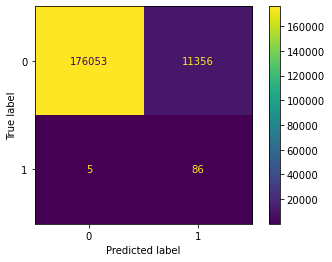

In [17]:
plot_confusion_matrix(model,X_test_scl,y_test)

In [18]:
print('Precision Score for the model:', precision_score(y_test,y_pred))
print('Recall score for the model:',recall_score(y_test,y_pred))

Precision Score for the model: 0.0075161685020101385
Recall score for the model: 0.945054945054945


### Approach 2: Custom Hyperparameter tuning 

In [19]:
results = list()
for c_num in c:
    model = LogisticRegression(class_weight = 'balanced', C = c_num)
    try:
        model.fit(X_train_scl,y_train)
        y_pred = model.predict(X_test_scl)
        results.append([c_num,roc_auc_score(y_test,y_pred),precision_score(y_test,y_pred),recall_score(y_test,y_pred)])
        
    except:
        print('Model cannot run for',c_num)
        

C:\Users\Nidhi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Nidhi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [21]:
res = pd.DataFrame(results,columns = ['C','ROC_AUC','Precision','Recall'])
res

,C,ROC_AUC,Precision,Recall
0,0.001000,0.872629,0.003179,0.879121
1,0.004642,0.907731,0.005083,0.901099
2,0.021544,0.920822,0.006248,0.912088
3,0.100000,0.935007,0.007031,0.934066
4,0.464159,0.936311,0.007328,0.934066
5,2.154435,0.936042,0.007264,0.934066
6,10.000000,0.942163,0.007500,0.945055
7,46.415888,0.942211,0.007512,0.945055
8,215.443469,0.942222,0.007514,0.945055
9,1000.000000,0.942230,0.007516,0.945055


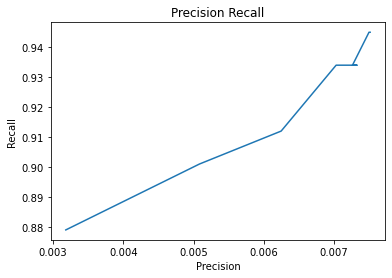

In [22]:
#Plotting Precision and Recall curve for different values of C
plt.plot(res['Precision'],res['Recall'])
plt.title('Precision Recall')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()

# Algorithm 2: RandomForestClassifier

In [23]:
est = np.linspace(70,120,10).astype('int64')
depth = np.linspace(2,8,4).astype('int64')
param = {'n_estimators':est,'max_depth':depth}

In [24]:
model = RandomForestClassifier(class_weight='balanced')
clf = RandomizedSearchCV(model, param,cv = 5, scoring = 'roc_auc')

clf.fit(X_train_scl,y_train)

print("Best Score:" + str(clf.best_score_))
print("Best Parameters: " + str(clf.best_params_))
best_est = clf.best_params_['n_estimators']
best_depth = clf.best_params_['max_depth']

Best Score:0.9799230805405463
Best Parameters: {'n_estimators': 97, 'max_depth': 8}


In [25]:
# Selected model with best ROC AUC score having 'max_depth':8, 'n_estiamtors': '83'

model = RandomForestClassifier(n_estimators = best_est,max_depth = best_depth,class_weight='balanced')
model.fit(X_train_scl,y_train)

y_pred = model.predict(X_test_scl)

In [26]:
print('Precision Score for the model:', precision_score(y_test,y_pred))
print('Recall score for the model:',recall_score(y_test,y_pred))

Precision Score for the model: 0.007651666970304245
Recall score for the model: 0.9230769230769231


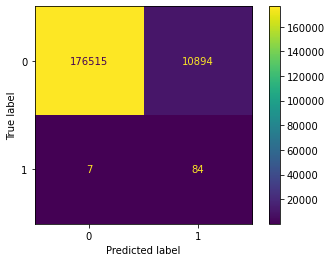

In [27]:
plot_confusion_matrix(model,X_test_scl, y_test)

# Trying to solve for the low Precision score 

In [28]:
from sklearn.cluster import KMeans

In [29]:
y.value_counts()

0    749566
1       434
Name: isFraud, dtype: int64

In [30]:
n_clus = df[df.isFraud == 1].isFraud.sum()
n_clus

434

In [31]:
nonFraud = df[df.isFraud == 0]
nonFraud.shape

(749566, 73)

In [32]:
X_nonFraud = nonFraud.drop(['isFraud'], axis = 1)
X_nonFraud.head(2)

#X_nonFraud_scl = StandardScaler().fit_transform(X_nonFraud)

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFlaggedFraud_0,isFlaggedFraud_1,CustTypeOrig_Customer,CustTypeDest_Customer,CustTypeDest_Merchant,Day_1.0,Day_10.0,Day_11.0,Day_12.0,Day_13.0,Day_14.0,Day_15.0,Day_16.0,Day_17.0,Day_18.0,Day_19.0,Day_2.0,Day_20.0,Day_21.0,Day_22.0,Day_23.0,Day_24.0,Day_25.0,Day_26.0,Day_27.0,Day_28.0,Day_29.0,Day_3.0,Day_30.0,Day_31.0,Day_32.0,Day_4.0,Day_5.0,Day_6.0,Day_7.0,Day_8.0,Day_9.0,Hour_0,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,transferAmntCheck_1
0,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [33]:
cluster = KMeans(n_clusters = n_clus, random_state = 42)
cluster.fit(nonFraud)

KMeans(n_clusters=434, random_state=42)

In [34]:
centroids = cluster.cluster_centers_
centroids.shape

(434, 73)

In [35]:
centroids[0]

array([1.31748369e+04, 7.99034468e+03, 4.43988091e+03, 1.63932507e+03,
       1.73341177e+03, 0.00000000e+00, 1.45893769e-02, 5.03163859e-02,
       4.00359645e-03, 9.27115318e-01, 3.97532246e-03, 1.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 7.28846817e-02, 9.27115318e-01,
       2.14254613e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.22292907e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.34524799e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.13069933e-03, 9.51136897e-03, 3.19496044e-03, 1.40238972e-03,
       1.35715134e-03, 1.76429674e-03, 4.50121861e-03, 1.61727201e-02,
      

In [36]:
centroids_df = pd.DataFrame(centroids,columns = df.columns)
centroids_df.head(2)

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFlaggedFraud_0,isFlaggedFraud_1,CustTypeOrig_Customer,CustTypeDest_Customer,CustTypeDest_Merchant,Day_1.0,Day_10.0,Day_11.0,Day_12.0,Day_13.0,Day_14.0,Day_15.0,Day_16.0,Day_17.0,Day_18.0,Day_19.0,Day_2.0,Day_20.0,Day_21.0,Day_22.0,Day_23.0,Day_24.0,Day_25.0,Day_26.0,Day_27.0,Day_28.0,Day_29.0,Day_3.0,Day_30.0,Day_31.0,Day_32.0,Day_4.0,Day_5.0,Day_6.0,Day_7.0,Day_8.0,Day_9.0,Hour_0,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,transferAmntCheck_1
0,13174.836931,7.990345e+03,4.439881e+03,1.639325e+03,1.733412e+03,0.0,0.014589,5.031639e-02,4.003596e-03,9.271153e-01,3.975322e-03,1.0,0.0,1.0,0.072885,9.271153e-01,0.214255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.722293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007131,0.009511,0.003195,1.402390e-03,1.357151e-03,1.764297e-03,4.501219e-03,1.617272e-02,0.034952,0.083996,0.086304,0.087174,0.099852,0.089747,0.071935,0.050921,0.052313,0.050316,0.059257,0.059681,0.056039,0.033103,0.024745,0.014629,1.0
1,180717.432672,8.803422e+06,8.984140e+06,3.937360e+06,3.901684e+06,0.0,1.000000,-2.775558e-16,-1.734723e-18,-5.551115e-17,2.775558e-17,1.0,0.0,1.0,1.000000,-5.551115e-17,0.155172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.797414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004310,0.004310,0.008621,-2.168404e-19,4.336809e-19,-1.084202e-19,-1.301043e-18,3.469447e-18,0.004310,0.090517,0.081897,0.107759,0.116379,0.094828,0.107759,0.077586,0.086207,0.051724,0.043103,0.038793,0.051724,0.017241,0.004310,0.008621,1.0


In [37]:
newDf = pd.concat([centroids_df,df[df['isFraud']==1]])
newDf.shape


(868, 73)

In [38]:
Xnew = newDf.drop(['isFraud'],axis = 1)
ynew = newDf.isFraud

In [39]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(Xnew,ynew, test_size = .25, random_state=42)

In [40]:
print('Shapes of training data:',X_train_new.shape,y_train_new.shape)
print('Shapes of test data:',X_test_new.shape,y_test_new.shape)

Shapes of training data: (651, 72) (651,)
Shapes of test data: (217, 72) (217,)


In [41]:
s = StandardScaler()
X_train_scl_new = s.fit_transform(X_train_new)
X_test_scl_new = s.transform(X_test_new)

In [42]:
c = np.logspace(-3,3,10)
param = {'C':c}
#penalize = ['l1','l2']

model = LogisticRegression(class_weight='balanced')
clf  = GridSearchCV(model,param, cv = 5,scoring = 'roc_auc')

clf.fit(X_train_scl_new,y_train_new)

print("Best Score:" + str(clf.best_score_))
print("Best Parameters: " + str(clf.best_params_))
best_c = clf.best_params_['C']

C:\Users\Nidhi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Nidhi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Best Score:0.9957489689797384
Best Parameters: {'C': 46.41588833612773}


C:\Users\Nidhi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Nidhi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [43]:
model = LogisticRegression(C=best_c,class_weight = 'balanced')
model.fit(X_train_scl_new,y_train_new)

y_pred_new = model.predict(X_test_scl_new)

C:\Users\Nidhi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [44]:
print('Precision Score for the model:', precision_score(y_test_new,y_pred_new))
print('Recall score for the model:',recall_score(y_test_new,y_pred_new))

Precision Score for the model: 0.9818181818181818
Recall score for the model: 1.0


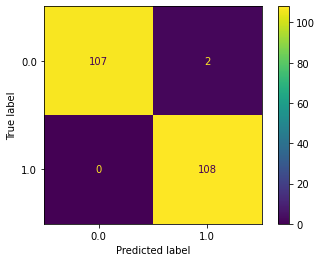

In [45]:
plot_confusion_matrix(model,X_test_scl_new, y_test_new)

In [46]:
# Random Forest

est = np.linspace(70,120,10).astype('int64')
depth = np.linspace(2,8,4).astype('int64')
param = {'n_estimators':est,'max_depth':depth}

In [47]:
model = RandomForestClassifier(class_weight='balanced')
clf = RandomizedSearchCV(model, param,cv = 5, scoring = 'roc_auc')

clf.fit(X_train_scl_new,y_train_new)

print("Best Score:" + str(clf.best_score_))
print("Best Parameters: " + str(clf.best_params_))
best_est = clf.best_params_['n_estimators']
best_depth = clf.best_params_['max_depth']

Best Score:1.0
Best Parameters: {'n_estimators': 103, 'max_depth': 4}


In [48]:

rand = RandomForestClassifier(n_estimators = best_est,max_depth = best_depth,class_weight='balanced')
rand.fit(X_train_scl_new,y_train_new)

y_pred_new = rand.predict(X_test_scl_new)

print('Precision Score for the model:', precision_score(y_test_new,y_pred_new))
print('Recall score for the model:',recall_score(y_test_new,y_pred_new))

Precision Score for the model: 1.0
Recall score for the model: 1.0


In [49]:
confusion_matrix(y_test_new, y_pred_new)

array([[109,   0],
       [  0, 108]], dtype=int64)

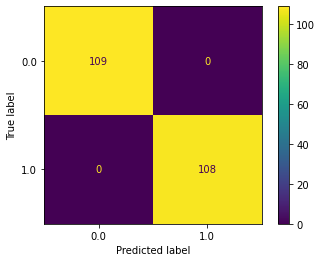

In [50]:
plot_confusion_matrix(rand,X_test_scl_new, y_test_new)